# Similarity of single-data parcellations

In [1]:
import matplotlib.pyplot as plt
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as ea
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import seaborn as sns
import re
import FusionModel.scripts.ari_group_prior as ag
import scipy.stats as stats
import PcmPy as pcm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations_with_replacement
import os
# import statsmodels.api as sm
# from statsmodels.formula.api import ols




In [2]:
# ---- Load results ----
try:
    with open(f'{ut.model_dir}/Models/Evaluation/nettekoven_68/ARI_granularity.npy', 'rb') as f:
        aris = np.load(f)
except FileNotFoundError:
    ARI, aris, labels, parcels = compare_across_granularity(
        ks=[10, 20, 34, 40, 68], exsting_included=False)

# Normalize aris by within-dataset reliability
ARI_avg = ea.average_comp_matrix(aris)
ARI_norm, aris_norm = ea.norm_comp_matrix(aris, ARI_avg)



In [3]:
# --- One sample t-test of ARI values of all between-dataset ARIs ---

# Get off-diagonal elements of aris_norm matrix
aris_norm_mat = np.array(aris_norm).reshape(8, 8, 5, 5)
# Get upper triangle elements
upper_tri = np.triu_indices(8, 1)
# Get the off diagonal elements of the 8x8 matrix
all_elements = np.array([aris_norm_mat[i, j] for i, j in zip(*upper_tri)])
# Get the diagonal elements of each 5x5 matrix
diag_elements = np.array([np.diag(aris_norm_mat[i, j]) for i, j in zip(*upper_tri)])


# One sample t-test
t, p = stats.ttest_1samp(all_elements.flatten(), 0)
print(f"t = {t}, p = {p}, df = {len(all_elements.flatten()) - 1}")

# One sample t-test of average off-diagonal matrices
t, p = stats.ttest_1samp(ARI_norm[upper_tri], 0)
print(f"t = {t}, p = {p}, df = {len(ARI_norm[upper_tri]) - 1}")

# One sample t-test of only the diagonal elements in the off-diagonal matrices
t, p = stats.ttest_1samp(diag_elements.flatten(), 0)
print(f"t = {t}, p = {p}, df = {len(diag_elements.flatten()) - 1}")


t = 61.397838234693396, p = 8.375247009064673e-284, df = 699
t = 17.88526014467397, p = 1.696391860449801e-16, df = 27
t = 28.127556852751894, p = 3.0835268925018186e-59, df = 139


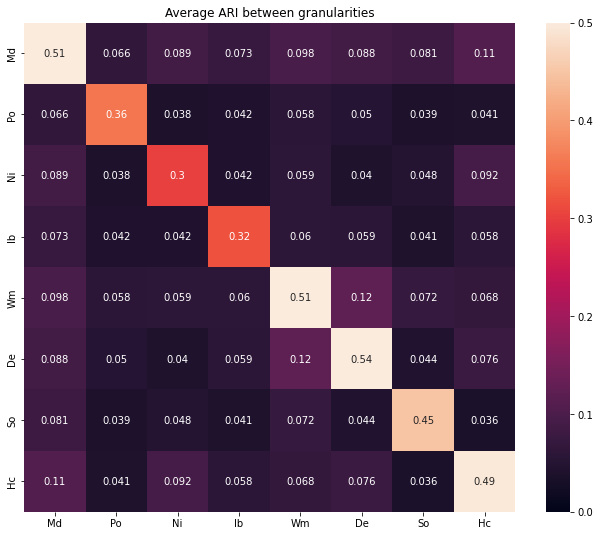

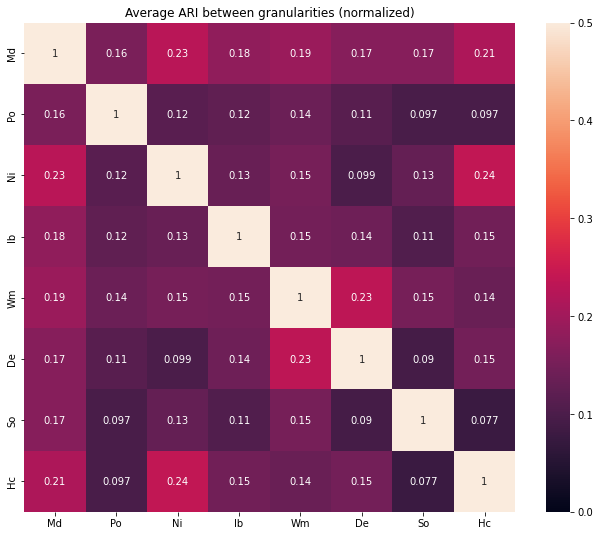

In [4]:
# ---- Plots ----
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                    'Wm', 'De', 'So', 'Hc']

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_avg, annot=True, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities')
plt.show()

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_norm, annot=True, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities (normalized)')
plt.show()


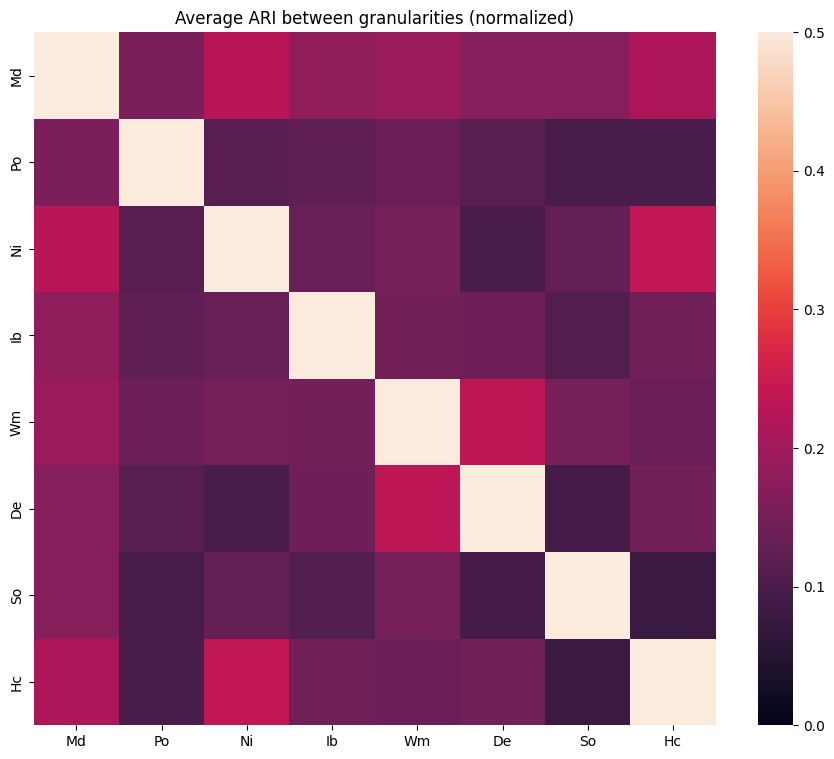

In [19]:
# ---- Plots ----
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                  'Wm', 'De', 'So', 'Hc']


fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_norm, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities (normalized)')
plt.savefig(f'{ut.figure_dir}/ARI_normalized.pdf')


In [20]:
# Make dataframe with reliability and similarity where indices are dataset_labels
df = pd.DataFrame({'Reliability': ARI_avg.diagonal(), 'SimilarityMDTB': ARI_avg[0], 'SimilarityHCP': ARI_avg[-1], 'SimilarityMDTB_norm': ARI_norm[0], 'SimilarityHCP_norm': ARI_norm[-1]},
                    index=dataset_labels)

## Reliability

In [5]:
# Get diagonal indices of a 8x8 matrix, namely 0, 10, 19, 28, 37, 46, 55, 64
new_row_indices = np.arange(0, aris.shape[0], np.sqrt(aris.shape[0]) + 1).astype(int)

reliabilities = aris[new_row_indices, :, :]
# flatten second and third dimension
reliabilities = reliabilities.reshape(reliabilities.shape[0], -1).T
# Reorder columns to have Hc and Md first
order = [0, 7, 1, 2, 3, 4, 5, 6]
reliabilities = reliabilities[:, order]
columns = [dataset_labels[i] for i in order]

# Make dataframe with reliabilities where columns are dataset_labels and rows are granularities
reliability = pd.DataFrame(reliabilities, columns=columns)



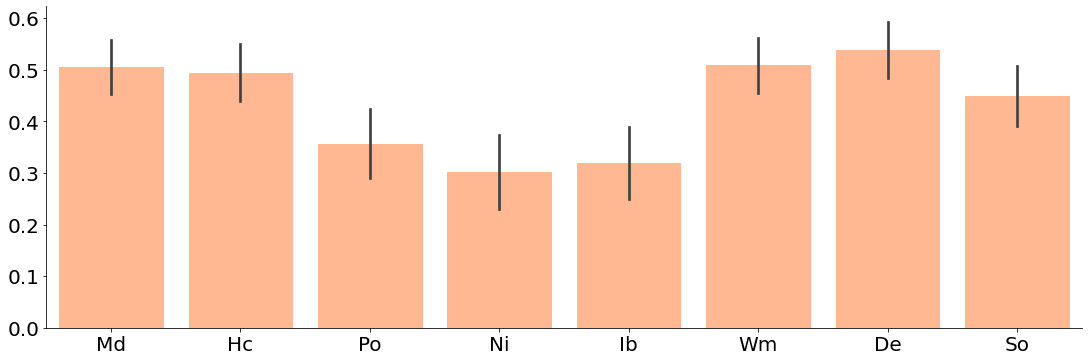

In [6]:
# Plot as bar plots with the columns on the x-axis and standard error of the mean as error bars
plt.figure(figsize=(15, 5))
ax = sb.barplot(data=reliability, errorbar='se')
colour_palette = ['FFB892', 'CF0154', '3F1643']
# Make bar colours into the first colour in colour_palette
for i, bar in enumerate(ax.patches):
    bar.set_color('#' + colour_palette[0])
    if i == 7:
        break
# Tight layout without upper and right border
plt.tight_layout()
sns.despine()
# Make ticks and labels bigger
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(f'{ut.figure_dir}/Reliability.pdf')


## Similarities

In [7]:
# Get Md & Hc similarities
similarities_md = aris_norm[0:8]
similarities_hc = aris_norm[-8:]


# Flatten each element of similarities
similarities_md = np.array([similarity.flatten() for similarity in similarities_md])
similarities_hc = np.array([similarity.flatten() for similarity in similarities_hc])

# Make dataframe with similarities where columns are dataset_labels and rows are granularities
df_md = pd.DataFrame(similarities_md, index=dataset_labels)
df_hc = pd.DataFrame(similarities_hc, index=dataset_labels)
df_md['similar_to'] = ['Md'] * 8
df_hc['similar_to'] = ['Hc'] * 8

# Make index a variable
df_md = df_md.reset_index().rename(columns={'index': 'dataset'})
df_hc = df_hc.reset_index().rename(columns={'index': 'dataset'})


# Combine into one dataframe
similarities = pd.concat([df_md, df_hc], axis=0)

# Make columns into variable
similarities = pd.melt(similarities, id_vars=['dataset', 'similar_to'], var_name='granularity' ,value_name='similarity')


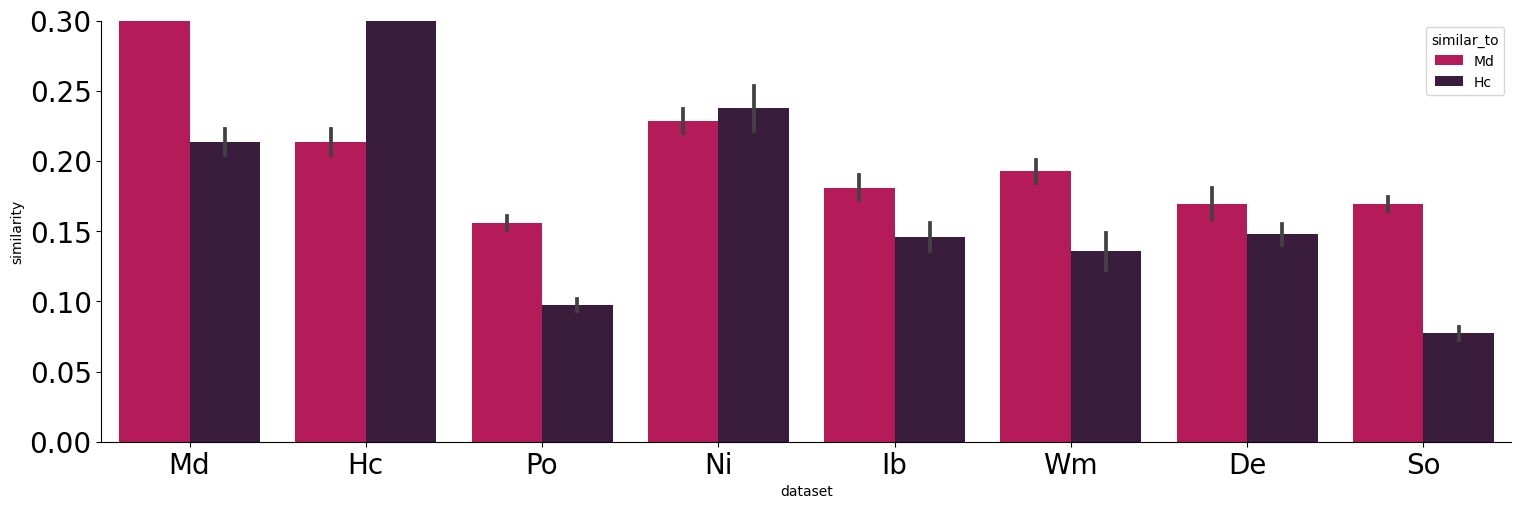

In [24]:
# Plot bar graph with seaborn with dataset on x_axis, similarity on y_axis and hue as similar_to and errorbars as standard error of the mean
plt.figure(figsize=(15, 5))
palette_similarity = ['#' + colour for colour in colour_palette[1:]]
ax = sb.barplot(data=similarities, x='dataset', y='similarity', hue='similar_to', errorbar='se',
                palette=palette_similarity, order=['Md', 'Hc', 'Po', 'Ni', 'Ib', 'Wm', 'De', 'So'])
# Make ylimits from 0 to 0.4
ax.set_ylim(0, 0.3)

# Tight layout without upper and right border
plt.tight_layout()
sns.despine()
# Make ticks and labels bigger
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(f'{ut.figure_dir}/Similarity.pdf')


In [25]:
# Plot Reliability and normalized Similarity into separate bar plots with seaborn with dataset on x axis
df_melt = df.iloc[1:-1][['Reliability', 'SimilarityMDTB_norm', 'SimilarityHCP_norm']].reset_index().melt(
    id_vars='index', var_name='Measure', value_name='Value')



In [26]:

# ---- Stats ----
# Test whether task based datasets are more similar to MDTB than to HCP
n_parcellations = int(np.sqrt(len(aris)))
mdtb_row = dataset_labels.index('Md')
hcp_row = dataset_labels.index('Hc')

mdtb_values = [aris_norm[i * n_parcellations + j]
               for j in np.arange(n_parcellations) for i in np.arange(n_parcellations) if i == mdtb_row and j != mdtb_row and j < hcp_row]
mdtb_values = [el for arr in mdtb_values for row in arr for el in row]

hcp_values = [aris_norm[i * n_parcellations + j]
              for j in np.arange(hcp_row) for i in np.arange(n_parcellations) if i == hcp_row and j <= hcp_row and j != mdtb_row  ]
hcp_values = [el for arr in hcp_values for row in arr for el in row]

# Print degrees of freedom
result = stats.ttest_rel(mdtb_values, hcp_values)
print(result.statistic, result.pvalue)
df = len(mdtb_values) - 1

# Print results
print(f'T = {result.statistic:.3f}, p = {result.pvalue:.3e}, df = {df}')
# Non scientific notation
print(f'T = {result.statistic:.3f}, p = {result.pvalue:.3f}, df = {df}')


9.604928265049354 2.671600189338409e-17
T = 9.605, p = 2.672e-17, df = 149
T = 9.605, p = 0.000, df = 149


In [ ]:
# # ANOVA with dataset and similarity as factors
# all_values = mdtb_values + hcp_values


# # Create a dataframe
# dataframe = pd.DataFrame({'Dataset': list(np.repeat(dataset_labels[1:-1], 25)) + list(np.repeat(dataset_labels[1:-1], 25)),
#                         'Similarity': np.repeat(['task', 'rest'], 150),
#                         'ari': all_values})


# # Performing two-way ANOVA
# model = ols('ari ~ C(Dataset) + C(Similarity) +\
# C(Dataset):C(Similarity)',
#             data=dataframe).fit()
# result = sm.stats.anova_lm(model, type=2)

In [30]:
# Run separate t-tests for each dataset to see if the difference is significant for each dataset
# ---- Stats ----
# Test whether task based datasets are more similar to MDTB than to HCP
mdtb_values = [aris_norm[i * n_parcellations + j]
               for j in np.arange(n_parcellations) for i in np.arange(n_parcellations) if i == mdtb_row and j != mdtb_row and j < hcp_row]
hcp_values = [aris_norm[i * n_parcellations + j]
              for j in np.arange(hcp_row) for i in np.arange(n_parcellations) if i == hcp_row and j <= hcp_row and j != mdtb_row  ]

for i in np.arange(0, len(mdtb_values)):
    result = stats.ttest_rel(mdtb_values[i].flatten(), hcp_values[i].flatten())
    df = len(mdtb_values[i].flatten()) - 1

    # Print results
    print(f'\n{dataset_labels[i+1]}\nT = {result.statistic:.3f}, p = {result.pvalue:.3e}, df = {df}')
    # Non scientific notation
    print(f'T = {result.statistic:.3f}, p = {result.pvalue:.3f}, df = {df}')



Po
T = 16.404, p = 1.523e-14, df = 24
T = 16.404, p = 0.000, df = 24

Ni
T = -0.838, p = 4.101e-01, df = 24
T = -0.838, p = 0.410, df = 24

Ib
T = 3.513, p = 1.786e-03, df = 24
T = 3.513, p = 0.002, df = 24

Wm
T = 4.727, p = 8.318e-05, df = 24
T = 4.727, p = 0.000, df = 24

De
T = 3.262, p = 3.305e-03, df = 24
T = 3.262, p = 0.003, df = 24

So
T = 12.538, p = 5.015e-12, df = 24
T = 12.538, p = 0.000, df = 24


In [193]:
# Alternative calculation: Only do the comparison within the same granularity
mdtb_values = [np.diagonal(aris_norm[i * n_parcellations + j]).tolist()
               for j in np.arange(n_parcellations) for i in np.arange(n_parcellations) if i == mdtb_row and j != mdtb_row and j < hcp_row]
mdtb_values = [el for lis in mdtb_values for el in lis]

hcp_values = [np.diagonal(aris_norm[i * n_parcellations + j]).tolist()
              for j in np.arange(hcp_row) for i in np.arange(n_parcellations) if i == hcp_row and j <= hcp_row and j != mdtb_row  ]
hcp_values = [el for lis in hcp_values for el in lis]

# Print degrees of freedom
result = stats.ttest_rel(mdtb_values, hcp_values)
print(result.statistic, result.pvalue)
df = len(mdtb_values) - 1

# Print results
print(f'T = {result.statistic:.3f}, p = {result.pvalue:.3e}, df = {df}')
# Non scientific notation
print(f'T = {result.statistic:.3f}, p = {result.pvalue:.3f}, df = {df}')


3.65045604330211 0.0010240900834881939
T = 3.650, p = 1.024e-03, df = 29
T = 3.650, p = 0.001, df = 29


In [32]:
# ---- PCM MDS ----
# Make mask that excludes HCP and MDTB rows/columns
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                  'Wm', 'De', 'So', 'Hc']

mask = np.ones_like(ARI_norm, dtype=bool)

mask[hcp_row, :] = False
mask[mdtb_row, :] = False
mask[:, hcp_row] = False
mask[:, mdtb_row] = False

W, Glam = pcm.util.classical_mds(ARI_norm, contrast=mask)


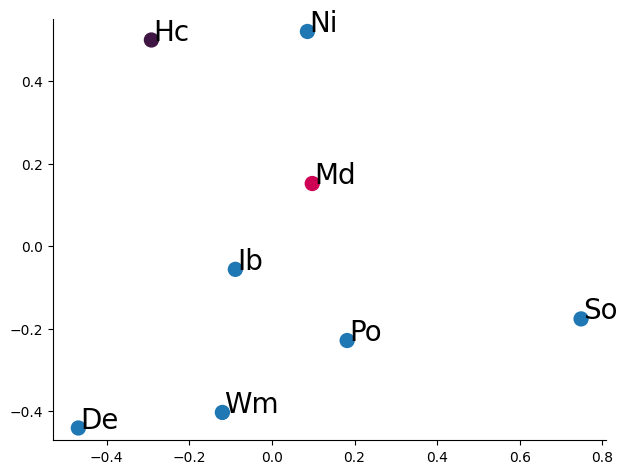

In [33]:
# Apply a rotation to the MDS solution
rotation_angle = np.pi / 2
# Apply rotation matrix
rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                            [np.sin(rotation_angle), np.cos(rotation_angle)]])
rotated_coordinates = np.dot(W[:, 1:3], rotation_matrix)

mdtb_point_color = '#CF0154'  # Red
hcp_point_color = '#3F1643'   # Blue

# Plot the rotated MDS solution with custom colors for the first and last points
colors = [mdtb_point_color if i == 0 else hcp_point_color if i == len(rotated_coordinates) - 1 else '#1f77b4'
          for i in range(len(rotated_coordinates))]

plt.scatter(rotated_coordinates[:, 0],
            rotated_coordinates[:, 1], s=100, c=colors)
for j in range(rotated_coordinates.shape[0]):
    plt.text(rotated_coordinates[j, 0] + 0.005, rotated_coordinates[j, 1], dataset_labels[j],
             fontdict=dict(alpha=1), fontsize=20)

plt.tight_layout()
sns.despine()
# Resize figure to be square
# Get the Matplotlib figure object
ax = plt.gca()
ax.axis('equal')

plt.savefig(f'{ut.figure_dir}/MDS_rotated.pdf')
